In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#data is in UTC
# wavemkaer frequency 3 [Hz] voltage 0.3 [V] expected displacement:	12.3 [mm]

In [2]:
data_dir = '/home/anna/annaCode/MEK4600/artemis_data/data/14_10_2024/'
matlab_io_dir = '/home/anna/annaCode/MEK4600/artemis_data/data/14_10_2024/matlab_io'

artemis_14_10_2024_data = 'dataLog00040.TXT'
df = pd.read_csv(os.path.join(data_dir,artemis_14_10_2024_data))
df['date_time_str'] = df['rtcDate'].astype(str) +' ' + df['rtcTime'].astype(str) 
df['time'] = pd.to_datetime(df['date_time_str'], format='%m/%d/%Y %H:%M:%S.%f')
df['time'] = pd.to_datetime(df['date_time_str'], format='%m/%d/%Y %H:%M:%S.%f')
# converting to local Oslo time
df['time'] += pd.Timedelta(hours=2)
df = df.drop(['Unnamed: 14', 'imu_degC', 'date_time_str', 'rtcDate', 'rtcTime','micros' ], axis=1)
df.head(1)

,aX,aY,aZ,gX,gY,gZ,mX,mY,mZ,output_Hz,time
0,15.63,-37.11,-978.52,-23.48,1.43,-2.31,11.55,4.2,-32.1,0.0,2024-10-14 11:39:03.340


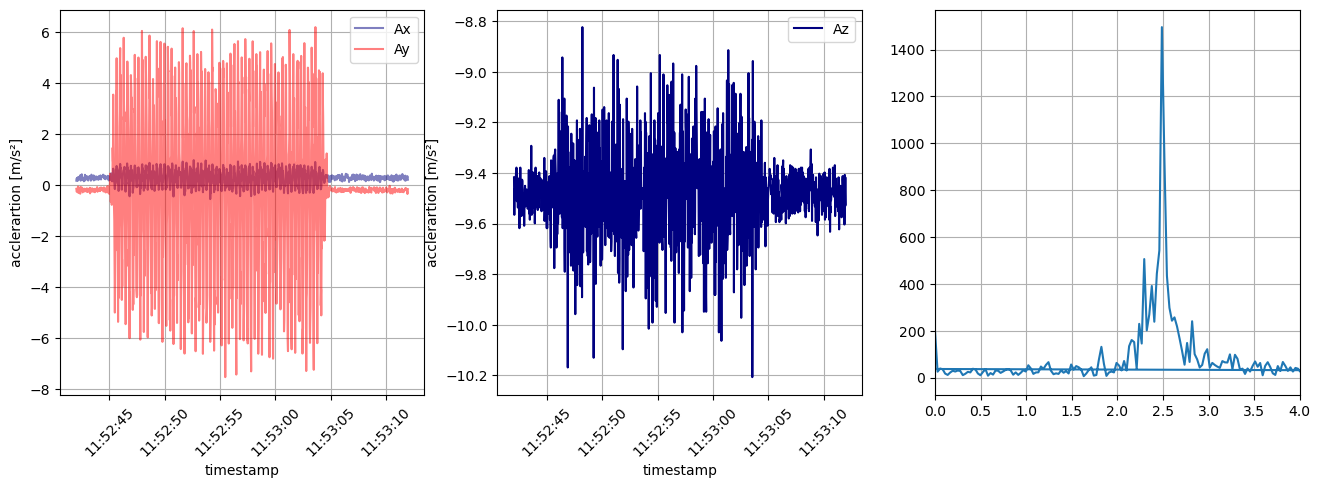

In [3]:
run_no = 8
high_pass = 2.1
low_pass = 3.2
time_thresholdl = pd.Timestamp('2024-10-14 11:52.700')
time_thresholdr = pd.Timestamp('2024-10-14 11:53.200')
run = df[df['time'] > time_thresholdl].copy()
run = run[run['time'] < time_thresholdr].copy()
run.to_csv(os.path.join(matlab_io_dir, f'run_{run_no}_raw.csv'))
run['aX_ms'] = run['aX'] * 0.0098 
run['aY_ms'] = run['aY'] * 0.0098 
run['aZ_ms'] = run['aZ'] * 0.0098 
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(16, 5))

ax.plot(run["time"], run['aX_ms'], label="Ax", color="navy", alpha = 0.5)
ax.plot(run["time"], run['aY_ms'], label="Ay", color="red", alpha = 0.5)
ax.set_ylabel("acclerartion [m/s²]")
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("timestamp")
ax.legend()
ax.grid(True)

ax1.plot(run["time"], run["aZ_ms"], label="Az", color="navy")
ax1.set_ylabel("acclerartion [m/s²]")
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel("timestamp")
ax1.legend()
ax1.grid(True)


run['time_diff'] = run['time'].diff().dt.total_seconds()
delta_t = run['time_diff'].dropna().iloc[0]
data = run['aY_ms']
fft_result = np.fft.fft(data)

n = len(run['aY_ms'])
frequencies = np.fft.fftfreq(n, delta_t)

#fig, (ax) = plt.subplots(1,1, figsize=(16, 5))
ax2.set_xlim(0, 4)  
ax2.plot(frequencies, np.abs(fft_result))
ax2.grid(True)

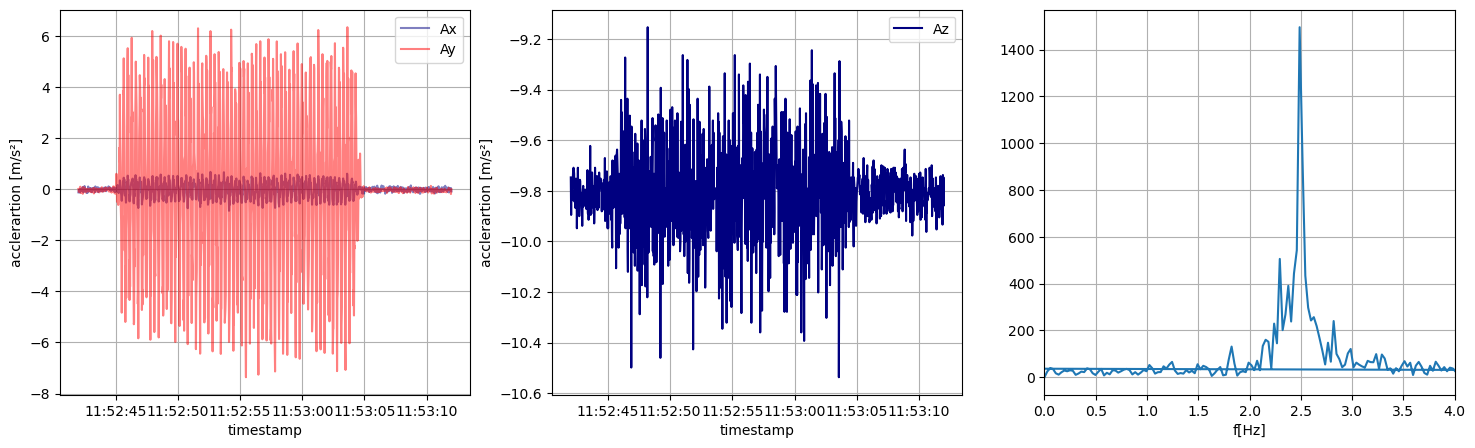

In [4]:
run['aX_ms'] = run['aX_ms'] - run['aX_ms'].mean()
run['aY_ms'] = run['aY_ms'] - run['aY_ms'].mean()
run['aZ_ms'] -= (9.81 + run["aZ_ms"].mean())
run.to_csv(os.path.join(matlab_io_dir, f'run_{run_no}_aligned.csv'))


fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(18, 5))
ax.plot(run["time"], run["aX_ms"], label="Ax", color="navy", alpha = 0.5)
ax.plot(run["time"], run["aY_ms"], label="Ay", color="red", alpha = 0.5)
ax.set_ylabel("acclerartion [m/s²]")
ax.set_xlabel("timestamp")
ax.legend()
ax.grid(True)

ax1.plot(run["time"], run["aZ_ms"], label="Az", color="navy")
ax1.legend()
ax1.set_ylabel("acclerartion [m/s²]")
ax1.set_xlabel("timestamp")
ax1.grid(True)
run["aX_ms"].mean(), run["aY_ms"].mean(), run['aZ_ms'].mean()

run['time_diff'] = run['time'].diff().dt.total_seconds()
delta_t = run['time_diff'].dropna().iloc[0]
data = run['aY_ms']
fft_result = np.fft.fft(data)

n = len(run['aY_ms'])
frequencies = np.fft.fftfreq(n, delta_t)

#fig, (ax) = plt.subplots(1,1, figsize=(16, 5))
ax2.set_xlim(0, 4)  
ax2.plot(frequencies, np.abs(fft_result))
ax2.set_xlabel("f[Hz]")
ax2.grid(True)

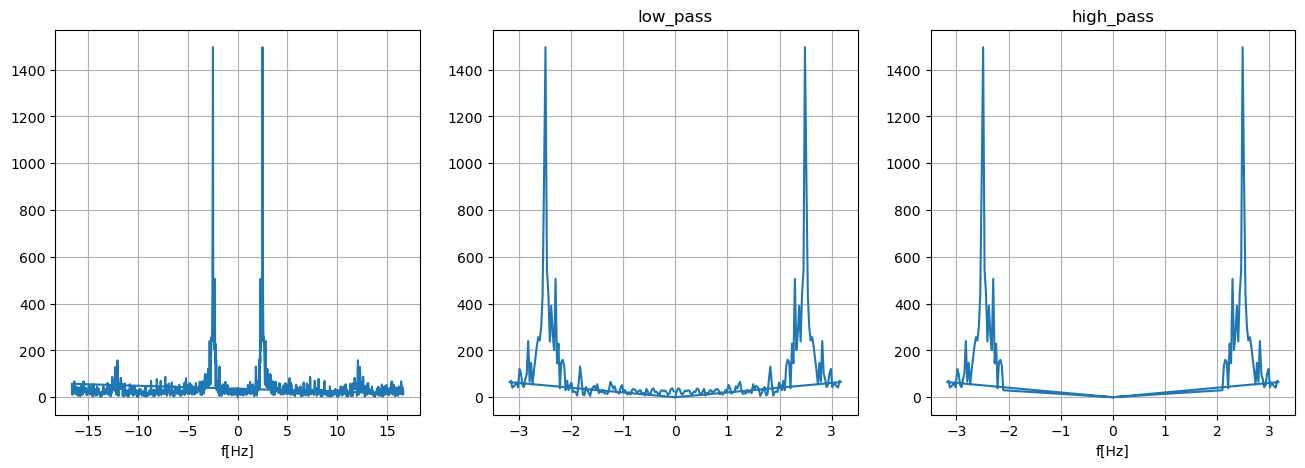

In [5]:
run['time_diff'] = run['time'].diff().dt.total_seconds()
delta_t = run['time_diff'].dropna().iloc[0]
data = run['aY_ms']
fft_result = np.fft.fft(data)

n = len(run['aY_ms'])
frequencies = np.fft.fftfreq(n, delta_t)

fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
ax.plot(frequencies, np.abs(fft_result))
ax.set_xlabel("f[Hz]")
ax.grid(True)

#00000000000000000000000000000000

filter_mask = np.abs(frequencies) < low_pass 
filterred_r = fft_result * filter_mask
filtered_freq = frequencies * filter_mask
ax2.set_title("low_pass")
ax2.plot(filtered_freq, np.abs(filterred_r))
ax3.set_xlabel("f[Hz]")
ax2.grid(True)

filter_mask = np.abs(filtered_freq) > high_pass 
filterred_r = fft_result * filter_mask
filtered_freq = frequencies * filter_mask
ax3.set_title("high_pass")
ax3.set_xlabel("f[Hz]")
ax3.plot(filtered_freq, np.abs(filterred_r))
ax3.grid(True)

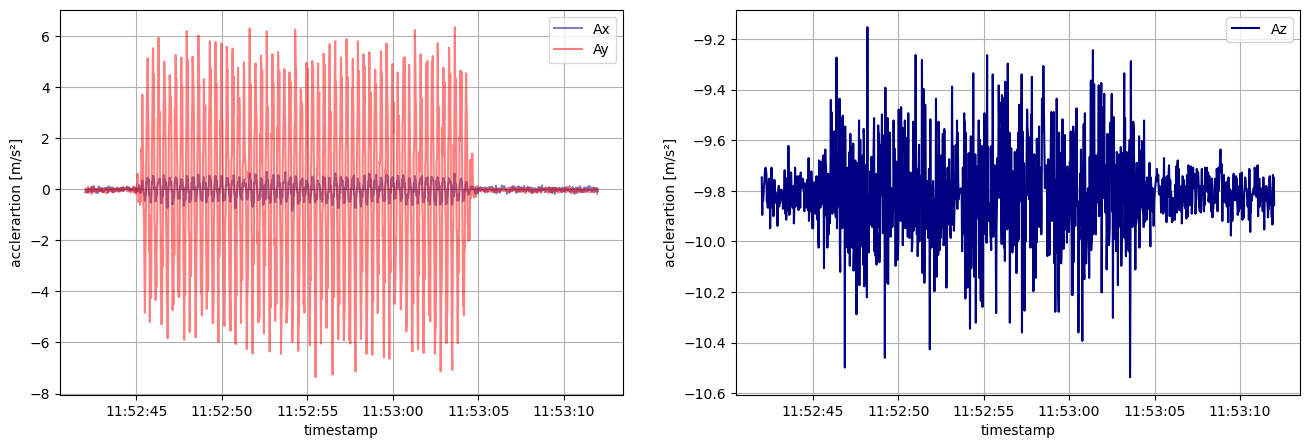

In [6]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(16, 5))
ax.plot(run["time"], run['aX_ms'], label="Ax", color="navy", alpha = 0.5)
ax.plot(run["time"], run['aY_ms'], label="Ay", color="red", alpha = 0.5)
ax.set_ylabel("acclerartion [m/s²]")
ax.set_xlabel("timestamp")
ax.legend()
ax.grid(True)

ax1.plot(run["time"], run["aZ_ms"], label="Az", color="navy")
ax1.set_ylabel("acclerartion [m/s²]")
ax1.set_xlabel("timestamp")
ax1.legend()
ax1.grid(True)

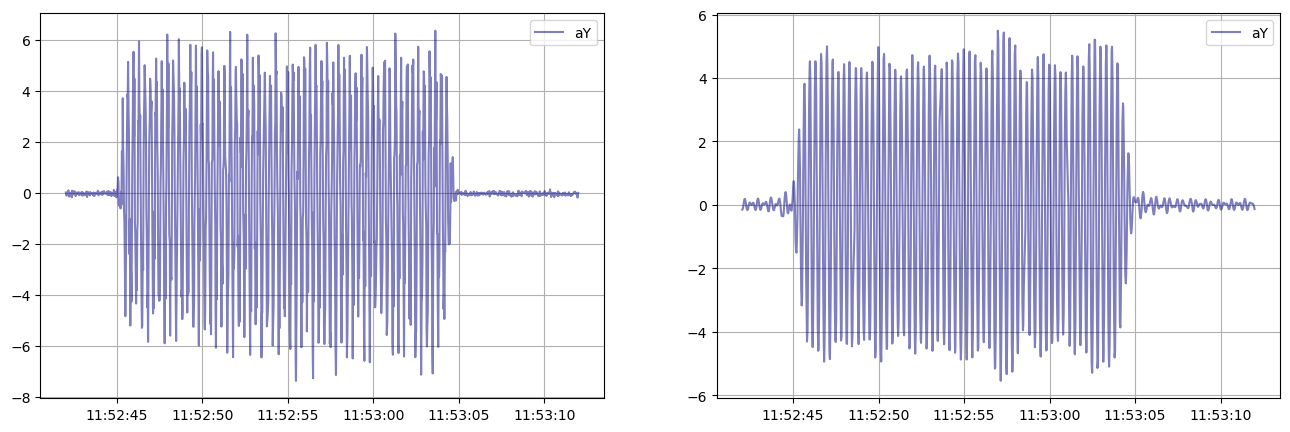

In [7]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax.plot(run["time"], run["aY_ms"], label="aY", color="navy", alpha = 0.5)
#ax.plot(last_run["time"], last_run["aY_ms"], label="Ay", color="red", alpha = 0.5)
ax.legend()
ax.grid(True)
filtered_aY_ms = np.fft.ifft(filterred_r).real
ax2.plot(run["time"], filtered_aY_ms, label="aY", color="navy", alpha = 0.5)
#ax.plot(last_run["time"], last_run["aY_ms"], label="Ay", color="red", alpha = 0.5)
ax2.legend()
ax2.grid(True)

In [8]:
def low_and_hight_pass(data, frequencies):
    fft_result = np.fft.fft(data)
    filter_mask = np.abs(frequencies) < low_pass 
    filterred_r = fft_result * filter_mask
    filtered_freq = frequencies * filter_mask
    filter_mask = np.abs(filtered_freq) > high_pass 
    filterred_r = fft_result * filter_mask
    filtered_freq = frequencies * filter_mask
    return np.fft.ifft(filterred_r).real

delta_t = run['time_diff'].dropna().iloc[0]
frequencies = np.fft.fftfreq(n, delta_t)

run['aX_ms'] = low_and_hight_pass(run['aX_ms'], frequencies) 
run['aY_ms'] = low_and_hight_pass(run['aY_ms'], frequencies)  
run['aZ_ms'] = low_and_hight_pass(run['aZ_ms'], frequencies)  
run.to_csv(os.path.join(matlab_io_dir, f'run_{run_no}_high_low_pass.csv'))

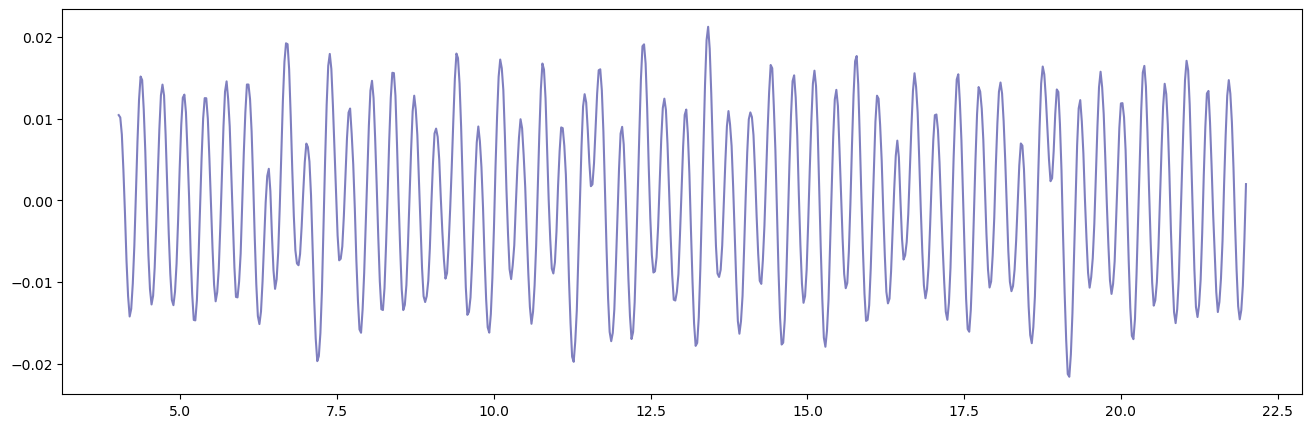

In [11]:
df = pd.read_csv(os.path.join(matlab_io_dir, f'run_{run_no}_disp.csv'), header=None, names=['time', 'disp'])
fig, (ax) = plt.subplots(1,1, figsize=(16, 5))
df= df[df['time']> 4].copy()
df= df[df['time']< 22].copy()
df.reset_index(inplace=True)
ax.plot(df["time"], df["disp"], label="disp", color="navy", alpha = 0.5)

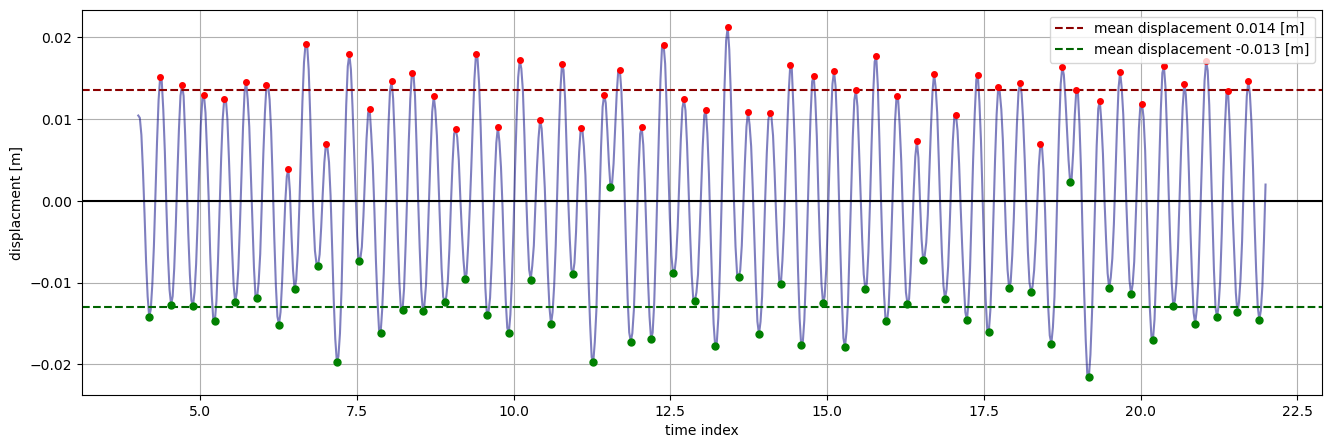

In [13]:
zero_crossings = np.where(np.diff(np.sign(df["disp"])))[0]
peaks, _ = find_peaks(df["disp"])
troughs, _ = find_peaks(-df["disp"])
peaks_df = df[df.index.isin(peaks)].copy()
troughs_df = df[df.index.isin(troughs)].copy()

fig, (ax) = plt.subplots(1,1, figsize=(16, 5))
ax.plot(df["time"], df["disp"], color="navy", alpha = 0.5)
ax.axhline(y=peaks_df["disp"].mean(), color='darkred', linestyle='--', label=f'mean displacement {round(peaks_df["disp"].mean(),3)} [m]')
ax.axhline(y=0, color='black', linestyle='-')
ax.axhline(y=troughs_df["disp"].mean(), color='darkgreen', linestyle='--',  label=f'mean displacement {round(troughs_df["disp"].mean(),3)} [m]')
ax.plot(peaks_df["time"], peaks_df["disp"], 'ro', ms = 4)
ax.plot(troughs_df["time"], troughs_df["disp"], 'go', ms = 5)
ax.set_xlabel("time index")
ax.set_ylabel("displacment [m]")
ax.legend()
ax.grid()

distances = []
for peak in peaks:
    # Find the nearest zero crossings on both sides
    left_zero = zero_crossings[zero_crossings < peak][-1]  # Last zero crossing before the peak
    right_zero = zero_crossings[zero_crossings > peak][0]  # First zero crossing after the peak

    # Calculate distances
    distance_left = peak - left_zero
    distance_right = right_zero - peak

    distances.append((distance_left, distance_right))

In [14]:
results = pd.read_csv(os.path.join(matlab_io_dir, 'results.csv'))
new_row = [int(run_no), peaks_df["disp"].mean(), troughs_df["disp"].mean(), peaks_df["disp"].std(), troughs_df["disp"].std()]
results.loc[results.shape[0]] = new_row
results.to_csv(os.path.join(matlab_io_dir, 'results.csv'), index = False)